# 四分位数の分布

* 黒木玄
* 2022-02-11

累積分布函数 $F(x)$ と密度函数 $p(x)$ を持つ分布のサイズ $n$ の標本の 25%, 50%, 75% 分位数をそれぞれ $Q_1, Q_2, Q_3$ と書く.

標本の四分位数の定義には揺れがあるが, その点を無視すれば, $(Q_1, Q_2, Q_3)$ の分布の確率測度は $\operatorname{Dirichlet}(n/4, n/4, n/4, n/4)$ 分布の $(t_1, t_2, t_3)$ ($t_i > 0$, $t_1+t_2+t_3<1$) に関する確率測度を $t_1 = F(q_1)$, $t_2 = F(q_2) - F(q_1)$, $t_3 = F(q_3) - F(q_2)$ で引き戻したものになる.

このことを使うと, Dirichlet分布の分散共分散行列を使って, 標本の四分位数 $Q_1, Q_2, Q_3$ の同時確率分布の分散共分散行列を書ける.

さらに, そのことを使えば $n$ が大きなときの正規分布近似も計算できる. 正規分布近似の分散共分散行列は

$$
a_i = F^{-1}(i/4), \quad
p_i = p(a_i) \quad
(i = 1,2,3)
$$

とおいたときの

$$
\frac{1}{16(n+1)}
\begin{bmatrix}
p_1^{-1} & & \\
& p_2^{-1} & \\
& & p_3^{-1} \\
\end{bmatrix}
\begin{bmatrix}
3 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 3 \\
\end{bmatrix}
\begin{bmatrix}
p_1^{-1} & & \\
& p_2^{-1} & \\
& & p_3^{-1} \\
\end{bmatrix}
$$

になる.  ここで出てきた行列 $\dfrac{1}{4}\begin{bmatrix}
3 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 3 \\
\end{bmatrix}$ は次の行列の逆行列として出てきた:
$$
\begin{bmatrix}
2 & -1 & 0 \\
-1 & 2 & -1 \\
0 & -1 & 2 \\
\end{bmatrix}
$$

具体的な公式については以下のコードを解読すれば分かるはず. 私が手計算で得た公式が間違っている可能性を心配していたが, 数値的に確認してみると, 十分に正しい公式を得ていそうなことがわかった.  Monte Carlo シミュレーションの結果とDirichlet分布の分散共分散行列を使って書いた公式を使って計算した結果とDirichlet分布の正規分布近似の分散共分散行列が近似的に一致していることが確認できた.

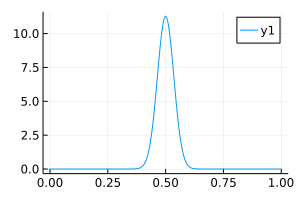

In [1]:
using LinearAlgebra
using StaticArrays
using Random
using Distributions
using StatsPlots
plot(Beta(100, 100); size=(300, 200))

In [2]:
function simquantile(; dist = Gamma(2, 1), n = 100, L = 10^5)
    Q = Matrix{Float64}(undef, L, 3)
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist, tmp[Threads.threadid()])
        Q[i, :] .= quantile.(Ref(X), (0.25, 0.50, 0.75))
    end
    Q
end

Q_exactvalue(; dist = Gamma(2, 1)) = quantile.(dist, SVector(0.25, 0.50, 0.75))

function covQ_exactvalue(; dist = Gamma(2, 1), n = 100)
    dir = Dirichlet(SVector(n/4, n/4, n/4, n/4))
    ET = @view cov(dir)[1:3, 1:3]
    L = @SMatrix [
        1 0 0
        1 1 0
        1 1 1
    ]
    EQ = L * ET * transpose(L)
    a = SVector(quantile.(dist, (0.25, 0.50, 0.75))...)
    pinv = @. 1 / pdf(dist, a)
    Σ = Symmetric(diagm(pinv) * EQ * diagm(pinv))
end

function covQ_normalapprox(; dist = Gamma(2, 1), n = 100)
    A = 1/(16(n+1)) * @SMatrix [
        3 2 1
        2 4 2
        1 2 3
    ]
    a = SVector(quantile.(dist, (0.25, 0.50, 0.75))...)
    pinv = @. 1 / pdf(dist, a)
    Σ = Symmetric(diagm(pinv) * A * diagm(pinv))
end

function comparequantile(; dist = Gamma(2, 1), n = 100, L = 10^5)
    Q_exact = Q_exactvalue(; dist)
    covQ_exact = covQ_exactvalue(; dist, n)
    covQ_normal = covQ_normalapprox(; dist, n)
    
    Q = simquantile(; dist, n, L)
    Q_simulation = mean.(eachcol(Q))
    covQ_simulation = cov(Q)
    
    @show dist
    @show n
    @show L
    println()
    
    @show Q_exact
    @show Q_simulation
    println("relative error: ", Q_simulation ./ Q_exact .- 1)
    

    println("\ncov(Q) exact value:")
    Base.print_matrix(stdout, covQ_exact); flush(stdout)
    
    println("\n\ncov(Q) simulation:")
    Base.print_matrix(stdout, covQ_simulation); flush(stdout)
    println("\n\nrelative error from exact value:")
    Base.print_matrix(stdout, covQ_simulation ./ covQ_exact .- 1)
    
    println("\n\ncov(Q) normal approx:")
    Base.print_matrix(stdout, covQ_normal); flush(stdout)
    println("\n\nrelative error from exact value:")
    Base.print_matrix(stdout, covQ_normal ./ covQ_exact .- 1)
    println("\n\nrelative error to simulation:")
    Base.print_matrix(stdout, covQ_simulation ./ covQ_normal .- 1)
end

comparequantile (generic function with 1 method)

In [3]:
comparequantile(; dist = Normal(2, 1), n = 100)

dist = Normal{Float64}(μ=2.0, σ=1.0)
n = 100
L = 100000

Q_exact = [1.3255102498039182, 2.0, 2.6744897501960816]
Q_simulation = [1.3347728336043425, 1.9996301655092277, 2.664341230007313]
relative error: [0.006987938268900207, -0.0001849172453861625, -0.0037945631266765867]

cov(Q) exact value:
 0.018383836327824452  0.009762402212108163  0.006127945442608152
 0.009762402212108163  0.015552438879157391  0.009762402212108164
 0.006127945442608152  0.009762402212108164  0.018383836327824452

cov(Q) simulation:
 0.018209216257824443  0.009826592154476274  0.006224908546594847
 0.009826592154476274  0.015404929286474769  0.009873559563800807
 0.006224908546594847  0.009873559563800807  0.018150240089857862

relative error from exact value:
 -0.009498565309554952   0.006575220009732652   0.015823101705916276
  0.006575220009732652  -0.009484659854880229   0.011386270436058776
  0.015823101705916276   0.011386270436058776  -0.01270660996981543

cov(Q) normal approx:
 0.018383836327824452  0.

In [4]:
comparequantile(; dist = Uniform(), n = 100)

dist = Uniform{Float64}(a=0.0, b=1.0)
n = 100
L = 100000

Q_exact = [0.25, 0.5, 0.75]
Q_simulation = [0.2549638447219144, 0.5000180700049351, 0.7449210694740704]
relative error: [0.01985537888765765, 3.614000987028909e-5, -0.006771907367906116]

cov(Q) exact value:
 0.0018564356435643566  0.0012376237623762379  0.000618811881188119
 0.0012376237623762379  0.0024752475247524757  0.001237623762376238
 0.000618811881188119   0.001237623762376238   0.001856435643564357

cov(Q) simulation:
 0.0018517795784776423  0.0012500478818599395  0.0006359770249479645
 0.0012500478818599395  0.0024233507933496394  0.001246868021257716
 0.0006359770249479645  0.001246868021257716   0.0018380724600279964

relative error from exact value:
 -0.002508067060043362   0.010038688542830965   0.027738872315910212
  0.010038688542830965  -0.020966279486745898   0.007469361176234202
  0.027738872315910212   0.007469361176234202  -0.009891634864919507

cov(Q) normal approx:
 0.0018564356435643563  0.00123762376237

In [5]:
comparequantile(; dist = Gamma(2, 1), n = 100)

dist = Gamma{Float64}(α=2.0, θ=1.0)
n = 100
L = 100000

Q_exact = [0.9612787631147769, 1.678346990016661, 2.692634528889696]
Q_simulation = [0.9742477921956185, 1.6832225327225359, 2.6821827738499513]
relative error: [0.013491434096410071, 0.0029049670508400904, -0.0038816092297733196]

cov(Q) exact value:
 0.013738437026395944  0.010745643698202766  0.00923434859663512
 0.010745643698202766  0.025214409383004503  0.021668189681356535
 0.00923434859663512   0.021668189681356535  0.055862158450998345

cov(Q) simulation:
 0.01385981056391071   0.011010260449945743  0.009493224666350707
 0.011010260449945743  0.025061376853641446  0.021825346947724377
 0.009493224666350707  0.021825346947724377  0.054789705741835074

relative error from exact value:
 0.0088345957608984     0.02462549095939548    0.028034036944405427
 0.02462549095939548   -0.006069249017040534   0.007252902465731292
 0.028034036944405427   0.007252902465731292  -0.01919819675611023

cov(Q) normal approx:
 0.01373843702639

In [6]:
comparequantile(; dist = Exponential(), n = 100)

dist = Exponential{Float64}(θ=1.0)
n = 100
L = 100000

Q_exact = [0.2876820724517809, 0.6931471805599453, 1.3862943611198906]
Q_simulation = [0.29610847787738, 0.6982605666766551, 1.381578768660844]
relative error: [0.029290686603390848, 0.007377056792727821, -0.003401580927759884]

cov(Q) exact value:
 0.0033003300330033004  0.003300330033003301  0.0033003300330033012
 0.003300330033003301   0.009900990099009903  0.009900990099009905
 0.0033003300330033012  0.009900990099009905  0.029702970297029712

cov(Q) simulation:
 0.003403743892259598   0.0034445276914105492  0.003442766829921952
 0.0034445276914105492  0.00997607789306991    0.009949872155288931
 0.003442766829921952   0.009949872155288931   0.02911795144849809

relative error from exact value:
 0.031334399354658204  0.04369189049739619     0.043158349466351
 0.04369189049739619   0.007583867200060768    0.0049370876841816624
 0.043158349466351     0.0049370876841816624  -0.019695634567231335

cov(Q) normal approx:
 0.003300330

In [7]:
comparequantile(; dist = LogNormal(), n = 100)

dist = LogNormal{Float64}(μ=0.0, σ=1.0)
n = 100
L = 100000

Q_exact = [0.5094162838632774, 1.0, 1.9630310841582572]
Q_simulation = [0.5188609297509814, 1.0077834451394598, 1.9633783461574634]
relative error: [0.018540133456430352, 0.0077834451394598325, 0.00017690091716260348]

cov(Q) exact value:
 0.004770696531933295  0.004973126656470779  0.006127945442608153
 0.004973126656470779  0.015552438879157391  0.019163898998423662
 0.006127945442608153  0.019163898998423662  0.07084194852177693

cov(Q) simulation:
 0.0048864835454209676  0.00517177649063458   0.006355342196351045
 0.00517177649063458    0.015809938332053658  0.01967158908980482
 0.006355342196351045   0.01967158908980482   0.0710904229403793

relative error from exact value:
 0.02427046296335078   0.039944656126006395  0.03710815572243531
 0.039944656126006395  0.01655685355184744   0.02649200412833097
 0.03710815572243531   0.02649200412833097   0.0035074475474936584

cov(Q) normal approx:
 0.004770696531933294  0.0049731

In [8]:
comparequantile(; dist = Gamma(2, 1), n = 10)

dist = Gamma{Float64}(α=2.0, θ=1.0)
n = 10
L = 100000

Q_exact = [0.9612787631147769, 1.678346990016661, 2.692634528889696]
Q_simulation = [1.090152725946955, 1.7299102451604924, 2.605870596843169]
relative error: [0.134065130508652, 0.03072264284474313, -0.032222691611365484]

cov(Q) exact value:
 0.12614383087872635  0.09866454668349808  0.0847881098418315
 0.09866454668349808  0.23151412251667763  0.1989533779833644
 0.0847881098418315   0.1989533779833644   0.5129161821409846

cov(Q) simulation:
 0.13569882709096265  0.12415011981930121  0.10965458939300883
 0.12415011981930121  0.23118906377188136  0.225878043117183
 0.10965458939300883  0.225878043117183    0.4663509987431624

relative error from exact value:
 0.07574683712771013   0.25830527775653045     0.2932779088667581
 0.25830527775653045  -0.0014040557926346953   0.1353315304657452
 0.2932779088667581    0.1353315304657452     -0.09078517118226315

cov(Q) normal approx:
 0.12614383087872635  0.0986645466834981  0.084788109

In [9]:
comparequantile(; dist = Gamma(2, 1), n = 20)

dist = Gamma{Float64}(α=2.0, θ=1.0)
n = 20
L = 100000

Q_exact = [0.9612787631147769, 1.678346990016661, 2.692634528889696]
Q_simulation = [1.0268767500481426, 1.7032662425954346, 2.645689284555893]
relative error: [0.06824033719502176, 0.014847497404887777, -0.017434688529067044]

cov(Q) exact value:
 0.06607533998409477   0.05168142921516568  0.044412819440959386
 0.05168142921516568   0.12126930227064071  0.10421367418176239
 0.044412819440959386  0.10421367418176239  0.26867038112146824

cov(Q) simulation:
 0.06840283265500588   0.058305491334357674  0.05118633854388376
 0.058305491334357674  0.12155147266582718   0.11199622034516213
 0.05118633854388376   0.11199622034516213   0.2544751750941723

relative error from exact value:
 0.03522483079877259  0.12817103202804225     0.15251270214737933
 0.12817103202804225  0.0023268081031482257   0.07467874273222486
 0.15251270214737933  0.07467874273222486    -0.052835023972658046

cov(Q) normal approx:
 0.06607533998409476   0.051681429

In [10]:
comparequantile(; dist = Gamma(2, 1), n = 40)

dist = Gamma{Float64}(α=2.0, θ=1.0)
n = 40
L = 100000

Q_exact = [0.9612787631147769, 1.678346990016661, 2.692634528889696]
Q_simulation = [0.9945756618418757, 1.6905673299978767, 2.6691701595379236]
relative error: [0.03463812996264348, 0.007281176094041442, -0.008714279305275019]

cov(Q) exact value:
 0.03384346682112171   0.026470975939475096  0.02274802946975967
 0.026470975939475096  0.0621135450654501    0.05337773555651241
 0.02274802946975967   0.05337773555651241   0.13761165862319097

cov(Q) simulation:
 0.03434816213871754   0.028106648328028987  0.024415348372990864
 0.028106648328028987  0.06186394337636293   0.05516499038893016
 0.024415348372990864  0.05516499038893016   0.13411328000100028

relative error from exact value:
 0.014912636470234553   0.06179116298144027    0.07329509157914793
 0.06179116298144027   -0.004018474373410186   0.033483151988070725
 0.07329509157914793    0.033483151988070725  -0.025422109268880777

cov(Q) normal approx:
 0.033843466821121715  0.

In [11]:
comparequantile(; dist = Gamma(2, 1), n = 80)

dist = Gamma{Float64}(α=2.0, θ=1.0)
n = 80
L = 100000

Q_exact = [0.9612787631147769, 1.678346990016661, 2.692634528889696]
Q_simulation = [0.9778029213081474, 1.6853824604742158, 2.6815845464129957]
relative error: [0.017189767242780096, 0.004191904593867646, -0.004103781021205566]

cov(Q) exact value:
 0.017130643699580124  0.013398889055783693  0.011514434669878355
 0.013398889055783693  0.031440189477573516  0.027018359973049497
 0.011514434669878355  0.027018359973049497  0.06965528399445471

cov(Q) simulation:
 0.017358129471444165  0.014007212838845689  0.012198342456275895
 0.014007212838845689  0.03182721036349516   0.027728796059705418
 0.012198342456275895  0.027728796059705418  0.06890684149794815

relative error from exact value:
 0.013279464324485124  0.04540106127674903    0.059395689498038085
 0.04540106127674903   0.012309750429389421   0.02629456737435487
 0.059395689498038085  0.02629456737435487   -0.010744949321664476

cov(Q) normal approx:
 0.017130643699580124  0

In [12]:
comparequantile(; dist = Gamma(2, 1), n = 160)

dist = Gamma{Float64}(α=2.0, θ=1.0)
n = 160
L = 100000

Q_exact = [0.9612787631147769, 1.678346990016661, 2.692634528889696]
Q_simulation = [0.9702626372628312, 1.6816631103051314, 2.6874911004188737]
relative error: [0.009345753274465851, 0.0019758252067039184, -0.0019101843995676937]

cov(Q) exact value:
 0.008618522606621057  0.006741055984586827  0.005792976448820786
 0.006741055984586827  0.01581773507877922   0.013593087936751607
 0.005792976448820786  0.013593087936751607  0.0350439627549741

cov(Q) simulation:
 0.008658639033894182  0.006856242957854769  0.005832036401083392
 0.006856242957854769  0.015822768967281183  0.013734688067359333
 0.005832036401083392  0.013734688067359333  0.034957253648258836

relative error from exact value:
 0.004654675645023643  0.017087378228472172    0.006742639575300968
 0.017087378228472172  0.0003182433184583111   0.010417068679801744
 0.006742639575300968  0.010417068679801744   -0.0024742951395517743

cov(Q) normal approx:
 0.0086185226066